In [8]:
import math
import numpy as np
import pandas as pd
from scipy.stats import linregress

nInst=100
currentPos = np.zeros(nInst)

# A basic theoretical price function
def getTheoreticalPrices(prcSoFar):
    # an array containing the latest prices of each stockie (I DONT KNOW HOW TRY AND EXCEPT WORK!)
    try:
        lastPrice = prcSoFar[:,-1]
        secondLastPrice = prcSoFar[:,-2]
    except:
        # Handle Day 1 when prcSoFar is a 1D array
        lastPrice = prcSoFar
        secondLastPrice = prcSoFar
    
    #RSIvalues = applyRSIModel(prcSoFar)
    #weightfactor = 1/3000 # 
    
    # The theoretical price is the last price with a basic mean reversion - 0.5 of the way to the 2nd last price
    theoreticalPrices = lastPrice + (secondLastPrice - lastPrice) * 0.8 #\
    #+ (50*np.ones(100) - rsi_values) * lastPrice * weightfactor
    return theoreticalPrices


# Applys the edge model to determine how much we should size up/down for each stockie
def applyEdgeModel(prcSoFar, theoPrices, currentPos): # theoPrices is a 100 length array with the edge for each

    # an array containing the latest prices of each stockie (I DONT KNOW HOW TRY AND EXCEPT WORK!)
    try:
        lastPrice = prcSoFar[:,-1]
    except:
        # Handle Day 1 when prcSoFar is a 1D array
        lastPrice = prcSoFar

    # Our edge is the theoretical price minus the current price expressed as a percentage (positive means buy)
    edgeArray = (theoPrices - lastPrice)/lastPrice
    newPosition = currentPos
    edgeRequired = 0.005 # if we have 1% of edge we will max out long and short based on direction
    for i in range(len(edgeArray)):
        edge = edgeArray[i]
        if (edge > edgeRequired).any():
            newPosition[i] = math.floor(10000/lastPrice[i]) # We buy as much as we allowed! Everything!
        if (edge < -edgeRequired).any():
            newPosition[i] = math.ceil(-10000/lastPrice[i]) # We sell as much as we allowed! Everything!
    return newPosition

# Function to change current position based on the results of the RSI Model
# Calculates the Relative Strength Index and uses the last RSI to determine the current stock position
def applyRSIModel(prcSoFar):
    
    # RSI Method
    prcSoFar = pd.DataFrame(prcSoFar).T
    RSI = prcSoFar.copy()
    for i in range(100):
        RSI[i] = computeRSI(prcSoFar[i], 14)
        RSI_copy = RSI.fillna(0).to_numpy()
    
    (row,col) = RSI[i].shape
    print(f'Row: {row}, Col: {col}')
    assert len(RSI[-1]) == 100, "Position is incorrect"
    return np.transpose(RSI_copy[-1])

# Dummy algorithm to demonstrate function format.
def getMyPosition(prcSoFar):
    global currentPos
    (nins,nt) = prcSoFar.shape
    #rpos = np.array([int(x) for x in 1000 * np.random.randn(nins)])
    #currentPos += rpos

    #currentPos = applyRSIModel(prcSoFar, currentPos)
    
    theoPrices = getTheoreticalPrices(prcSoFar)
    currentPos = applyEdgeModel(prcSoFar, theoPrices, currentPos)
    # The algorithm must return a vector of integers, indicating the position of each stock.
    # Position = number of shares, and can be positve or negative depending on long/short position.
    return currentPos

# Function to check that the position does not exceed 10k limit per stock
# Input: currentPos, a 1*100 nparray & latest price of each stock
# Output: True (Valid Position) or False (at least one stock exceeding 10k limit)
def isPositionValid(currentPos, prcSoFar):
    limit = 10000
    result = True

    try:
        lastPrice = prcSoFar[-1,:]
    except:
        # Handle Day 1 when prcSoFar is a 1D array
        lastPrice = prcSoFar

    assert lastPrice.shape == currentPos.shape, "The dimension of the current position does not match data."
    
    positionValue = abs(currentPos)*lastPrice

    stockNumber = 0
    for pos in positionValue:
        if pos > limit:
            result = False
            print(f"Stock {stockNumber}'s position exceeds limit")
        stockNumber += 1
        assert stockNumber < 100, "More stocks than expected."

    return result

# Calculate the momentum for one stock given the stocks historical data
# Code from https://teddykoker.com/2019/05/momentum-strategy-from-stocks-on-the-move-in-python/
# Formula of momentum is the annualised exponential regression slope multiplied
# by the R^2 coefficient of the regression calculation
def momentum(prices):
    returns = np.log(prices)
    x = np.arange(len(returns))
    slope, _, rvalue, _, _ = linregress(x, returns)
    return ((1 + slope) ** 252) * (rvalue ** 2)

# Calculating the RSI index for each stock 
def computeRSI (data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff<0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=time_window-1 so we get decay alpha=1/time_window
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi


In [9]:
# Algorithm testing file. 
# Quantitative judging will be determined from output of this program.
# Judging will use unseeen, future price data from the same universe.

nInst = 0
nt = 0

# Commission rate.
commRate = 0.0050

# Dollar position limit (maximum absolute dollar value of any individual stock position).
dlrPosLimit = 10000

def loadPrices(fn):
    global nt, nInst
    df=pd.read_csv(fn, sep='\s+', header=None, index_col=None)
    nt, nInst = df.values.shape
    return (df.values).T

pricesFile="./prices250.txt"
prcAll = loadPrices(pricesFile)
print ("Loaded %d instruments for %d days" % (nInst, nt))

def calcPL(prcHist):
    cash = 0
    curPos = np.zeros(nInst)
    totDVolume = 0
    totDVolume0 = 0
    totDVolume1 = 0
    frac0 = 0.
    frac1 = 0.
    value = 0
    todayPLL = []
    (_,nt) = prcHist.shape
    for t in range(1,200):
        prcHistSoFar = prcHist[:,:t]
        newPosOrig = getMyPosition(prcHistSoFar)
        curPrices = prcHistSoFar[:,-1] 
        posLimits = np.array([int(x) for x in dlrPosLimit / curPrices])
        newPos = np.array([int(p) for p in np.clip(newPosOrig, -posLimits, posLimits)])
        deltaPos = newPos - curPos
        dvolumes = curPrices * np.abs(deltaPos)
        dvolume0 = np.sum(dvolumes[:50])
        dvolume1 = np.sum(dvolumes[50:])
        dvolume = np.sum(dvolumes)
        totDVolume += dvolume
        totDVolume0 += dvolume0
        totDVolume1 += dvolume1
        comm = dvolume * commRate
        cash -= curPrices.dot(deltaPos) + comm
        curPos = np.array(newPos)
        posValue = curPos.dot(curPrices)
        todayPL = cash + posValue - value
        todayPLL.append(todayPL)
        value = cash + posValue
        ret = 0.0
        if (totDVolume > 0):
            ret = value / totDVolume
            frac0 = totDVolume0 / totDVolume
            frac1 = totDVolume1 / totDVolume
        print ("Day %d value: %.2lf todayPL: $%.2lf $-traded: %.0lf return: %.5lf frac0: %.4lf frac1: %.4lf" % (t,value, todayPL, totDVolume, ret, frac0, frac1))
    pll = np.array(todayPLL)
    (plmu,plstd) = (np.mean(pll), np.std(pll))
    annSharpe = 0.0
    if (plstd > 0):
        annSharpe = 16 * plmu / plstd
    return (plmu, ret, annSharpe, totDVolume)

# Output.
(meanpl, ret, sharpe, dvol) = calcPL(prcAll)
print ("=====")
print ("mean(PL): %.0lf" % meanpl)
print ("return: %.5lf" % ret)
print ("annSharpe(PL): %.2lf " % sharpe)
print ("totDvolume: %.0lf " % dvol)

Loaded 100 instruments for 250 days
Day 1 value: -4995.24 todayPL: $-4995.24 $-traded: 999048 return: -0.00500 frac0: 0.4999 frac1: 0.5001
Day 2 value: -5051.35 todayPL: $-56.12 $-traded: 1735081 return: -0.00291 frac0: 0.4028 frac1: 0.5972
Day 3 value: 996.96 todayPL: $6048.32 $-traded: 2444643 return: 0.00041 frac0: 0.3515 frac1: 0.6485
Day 4 value: 3812.87 todayPL: $2815.91 $-traded: 3111194 return: 0.00123 frac0: 0.3213 frac1: 0.6787
Day 5 value: 14161.71 todayPL: $10348.84 $-traded: 3973268 return: 0.00356 frac0: 0.2874 frac1: 0.7126
Day 6 value: 21419.12 todayPL: $7257.41 $-traded: 4898146 return: 0.00437 frac0: 0.2985 frac1: 0.7015
Day 7 value: 30992.80 todayPL: $9573.68 $-traded: 5721890 return: 0.00542 frac0: 0.2906 frac1: 0.7094
Day 8 value: 41559.11 todayPL: $10566.31 $-traded: 6602319 return: 0.00629 frac0: 0.2734 frac1: 0.7266
Day 9 value: 47835.19 todayPL: $6276.08 $-traded: 7326886 return: 0.00653 frac0: 0.2654 frac1: 0.7346
Day 10 value: 50997.69 todayPL: $3162.51 $-tra

In [3]:
prcSoFar = prcAll

In [8]:
try:
        lastPrice = prcSoFar[:,-1]
        secondLastPrice = prcSoFar[:,-2]
except:
        # Handle Day 1 when prcSoFar is a 1D array
        lastPrice = prcSoFar
        secondLastPrice = prcSoFar
        
# The theoretical price is the last price with a basic mean reversion - 0.5 of the way to the 2nd last price
theoreticalPrices = lastPrice + (secondLastPrice - lastPrice) * 0.5
theoreticalPrices


array([19.2  ,  7.39 , 19.145,  0.455,  2.35 ,  8.34 , 16.54 , 21.195,
       20.21 ,  2.595, 33.805,  1.06 ,  7.795, 14.995, 27.365, 29.77 ,
       30.24 , 24.295,  5.51 , 42.495, 14.23 ,  1.8  ,  7.12 ,  9.895,
        6.06 , 48.71 , 14.93 , 16.705, 12.34 , 26.14 , 25.58 , 17.925,
       14.8  ,  6.515, 30.8  ,  8.11 , 16.63 , 11.86 , 23.47 , 23.705,
        8.34 , 69.68 , 17.93 , 82.965, 35.8  , 60.325, 66.345, 26.435,
       37.575, 41.935, 13.08 ,  9.01 , 17.52 , 12.505, 18.15 ,  9.025,
       15.66 , 16.54 , 22.675,  0.52 , 14.705, 21.545, 10.075, 16.135,
       18.525, 20.695, 15.065, 15.45 , 10.115, 26.195, 15.435, 30.01 ,
       27.465, 24.875,  8.995, 13.335, 18.31 , 19.13 , 21.47 ,  6.47 ,
       19.215, 28.74 , 17.575, 19.385,  3.815, 26.835, 18.82 , 20.605,
       29.04 , 11.395,  7.635, 19.135, 19.845, 20.04 , 27.22 , 16.   ,
       19.83 ,  3.355,  2.545, 19.01 ])

In [5]:
# an array containing the latest prices of each stockie (I DONT KNOW HOW TRY AND EXCEPT WORK!)
try:
    lastPrice = prcAll[:,-1]
except:
    # Handle Day 1 when prcSoFar is a 1D array
    lastPrice = prcAll

# Our edge is the theoretical price minus the current price expressed as a percentage (positive means buy)
edgeArray = (theoreticalPrices - lastPrice)/lastPrice
len(edgeArray)
newPosition = currentPos
edgeRequired = 0.005 # if we have 1% of edge we will max out long and short based on direction
for i in range(len(edgeArray)):

    if edgeArray[i] > edgeRequired:
        newPosition[i] = math.floor(10000/lastPrice[i]) # We buy as much as we allowed! Everything!
    if edgeArray[i] < -edgeRequired:
        newPosition[i] = math.ceil(-10000/lastPrice[i]) # We sell as much as we allowed! Everything!
        
        
newPosition

NameError: name 'theoreticalPrices' is not defined

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
from scipy.ndimage import gaussian_filter1d
import random

df = pd.read_csv('prices500.txt', sep='     ', header=None)
#print(df)

NUM_DAYS = df.shape[0]
NUM_STOCKS = df.shape[1]

def convert_to_percentage_growth(df):
    percent_df = df.copy()
    percent_df.iloc[0,:] = np.zeros(len(df.iloc[0,:]))
    for i in range(1, df.shape[0]):
        percent_df.iloc[i,:] = (df.iloc[i,:] - df.iloc[0,:]) / df.iloc[0,:]
    return percent_df

percent_df = convert_to_percentage_growth(df)
print(percent_df)
df1.to_excel("percent_df.xlsx")  


# final_return = (df.iloc[df.shape[0]-1,:] - df.iloc[0,:]) / df.iloc[0,:]
# print(final_return)
# print(sum(final_return) / len(final_return))



def plot_df(df):
    for i in range(df.shape[1]):
        data = df.iloc[:,i]
        plt.plot(data)
    plt.show()


def get_std_dev(df):
    """Returns a list containing the standard deviations for every stock in the dataframe."""
    std_devs = []
    for i in range(df.shape[1]):
        std_devs.append(np.std(df.iloc[:,i].values))
    return std_devs


def get_mean_price(df):
    means = []
    for i in range(df.shape[1]):
        means.append(np.mean(df.iloc[:,i].values))
    return means


def gaussian_filter(df, std_dev):
    new_df = df.copy()
    for i in range(df.shape[1]):
        new_df.iloc[:,i] = gaussian_filter1d(df.iloc[:,i], std_dev)
    return new_df


def get_price_change(df):
    new_df = df.copy()
    new_df.iloc[0,:] = np.zeros(df.shape[1])
    for i in range(1, df.shape[0]):
        new_df.iloc[i,:] = df.iloc[i,:] - df.iloc[i-1,:]
    return new_df


def filter_stocks(df, keep_function=None, index_set=None):
    drop_columns = []
    for i in range(df.shape[1]):
        if keep_function is not None and not keep_function(df.iloc[:,i].values):
            drop_columns.append(i)
        if index_set is not None and i not in index_set:
            drop_columns.append(i)
    return df.drop(drop_columns, axis=1)


index_set = {1, 2, 3, 4, 5}

# percent_df = filter_stocks(percent_df, keep_function=(lambda arr: random.randint(1,30) == 1), index_set=index_set)

percent_df = filter_stocks(percent_df, keep_function=None, index_set=index_set)

plot_df(percent_df)

filtered_percent_df = gaussian_filter(percent_df, 10)
plot_df(filtered_percent_df)

price_change_df = get_price_change(percent_df)
plot_df(price_change_df)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


           0         1         2         3         4         5         6   \
0    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1   -0.001644  0.001362  0.003343  0.000000  0.000000 -0.009456  0.000569   
2    0.001644  0.000000  0.005014  0.000000  0.000000 -0.004728 -0.002846   
3   -0.009863  0.001362  0.002228  0.000000  0.000000 -0.022459 -0.002277   
4   -0.002740  0.004087 -0.000557  0.017544  0.000000 -0.004728 -0.008537   
5   -0.005479  0.008174  0.007799  0.000000  0.000000  0.007092 -0.003415   
6   -0.000548  0.009537  0.016713  0.000000  0.004149  0.001182 -0.001138   
7    0.007671  0.010899  0.021727  0.000000  0.004149  0.001182  0.000569   
8    0.004932  0.012262  0.021170  0.000000  0.000000 -0.015366  0.003984   
9    0.008767  0.013624  0.030084  0.017544  0.004149 -0.014184  0.014798   
10   0.006027  0.013624  0.026741  0.035088  0.004149  0.004728  0.003984   
11   0.009863  0.010899  0.021727  0.035088  0.004149 -0.004728 -0.005122   

NameError: name 'df1' is not defined

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


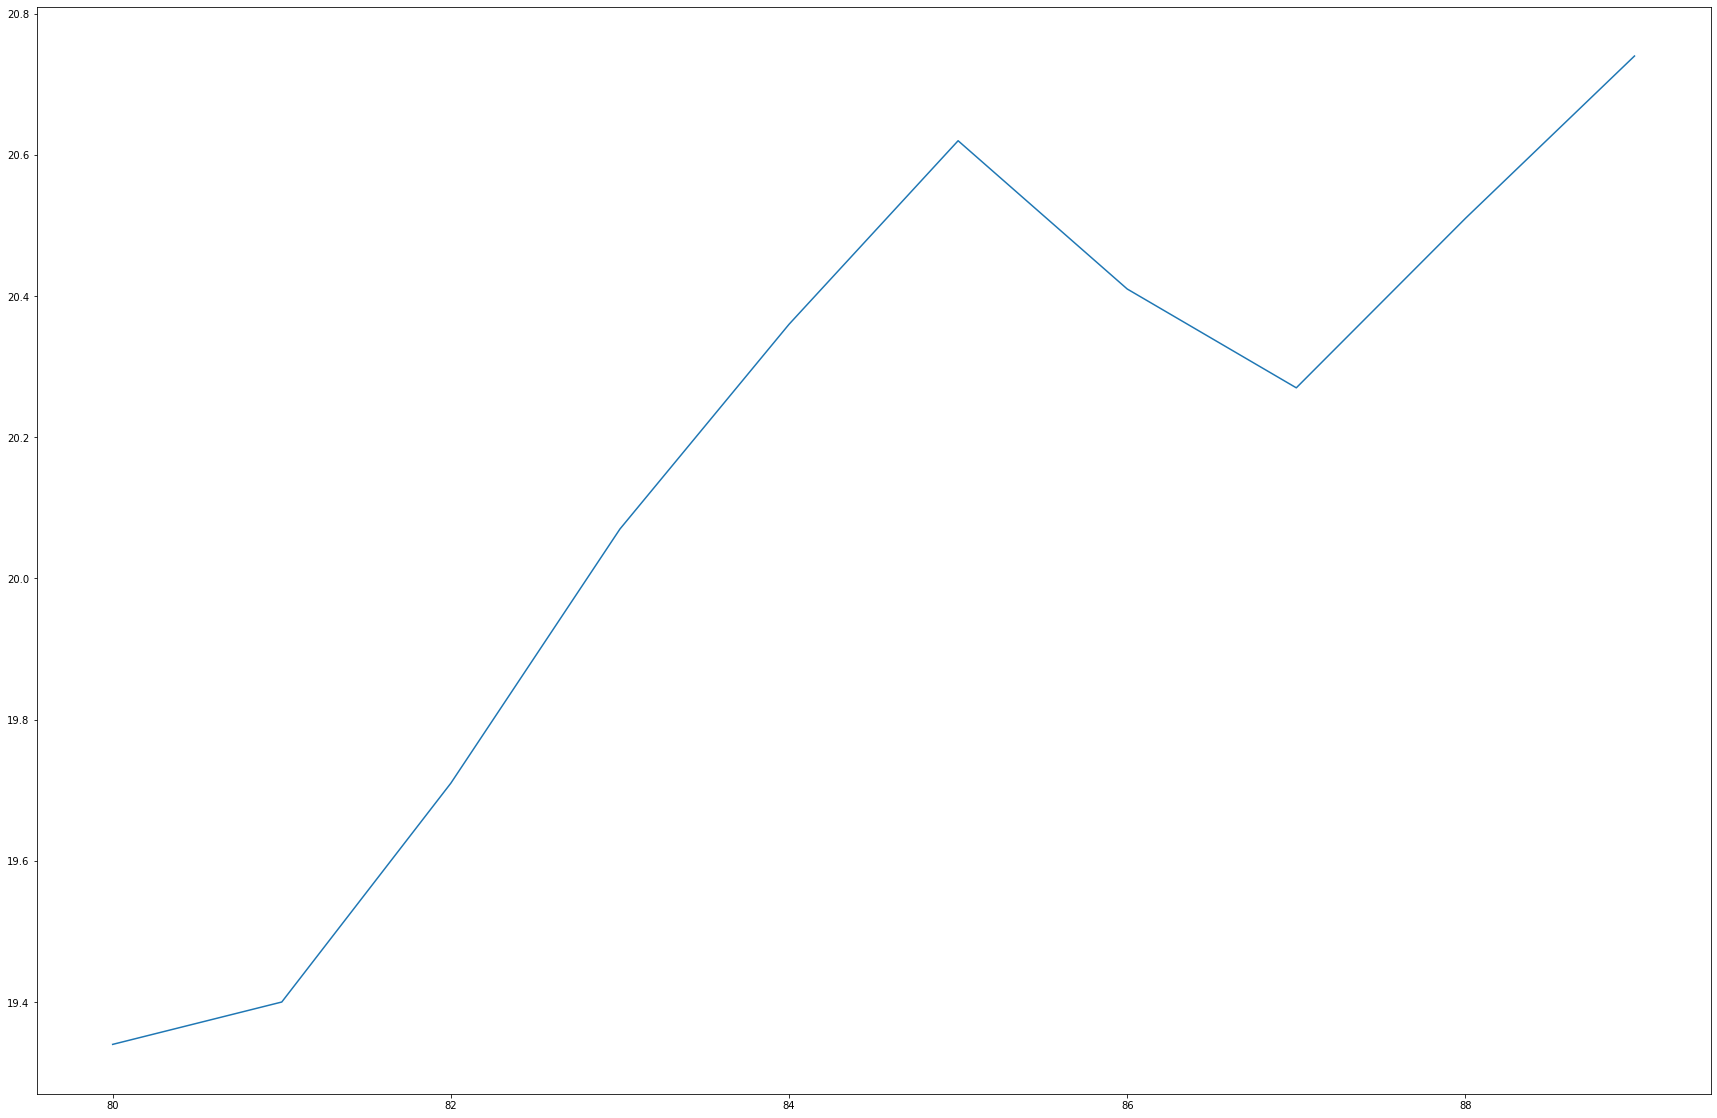

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
from scipy.ndimage import gaussian_filter1d
import random

df = pd.read_csv('prices500.txt', sep='     ', header=None)

data = df.iloc[:,7]
data1 = data.iloc[80:90]
data2 = data.iloc[251:500]
plt.figure(figsize=(30, 20))
plt.plot(data1)


plt.show()


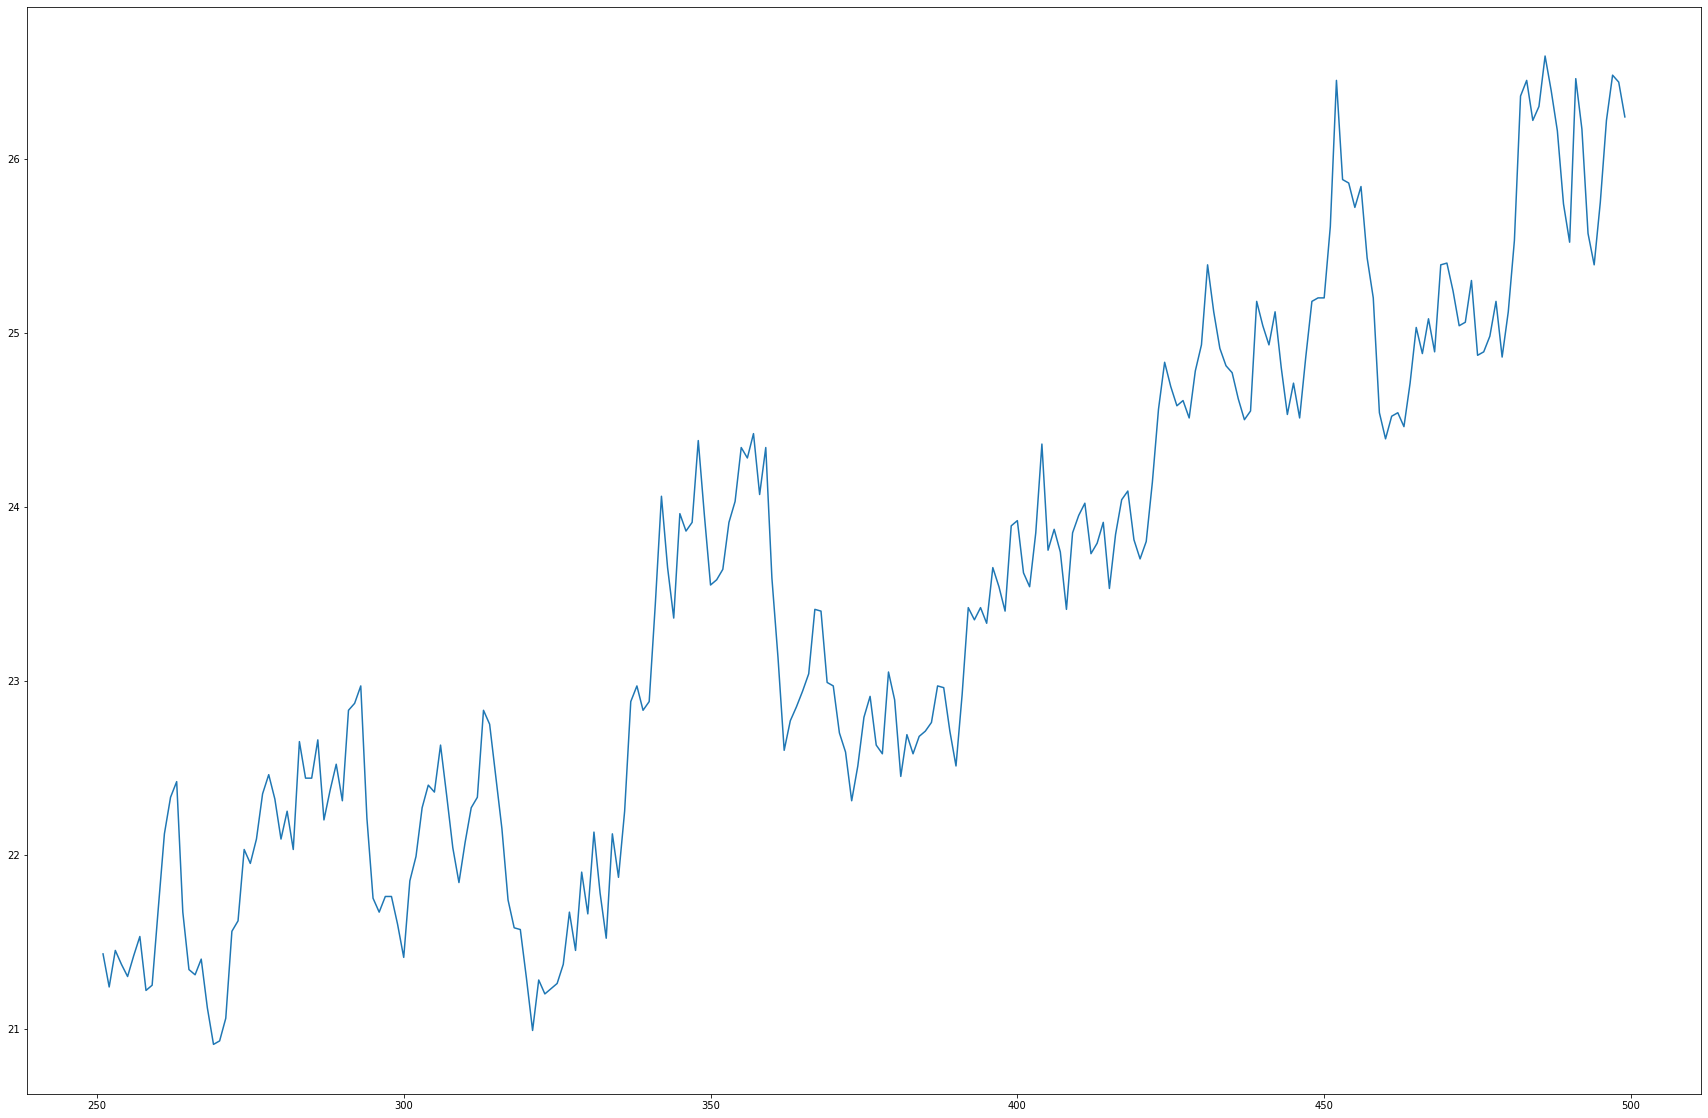

In [29]:
plt.figure(figsize=(30, 20))
plt.plot(data2)

plt.show()

In [35]:
print(percent_df)
out_path = "C:\Users\chees\OneDrive - The University of Sydney (Students)\UNIVERSITY\Y4 SEM 1\MTRX2700\Astronauts---Sig-Algothon-2021/percentDF.xlsx"
writer = pd.ExcelWriter(out_path , engine='xlsxwriter')
percent_df.to_excel(writer, sheet_name='Sheet1')
writer.save()


SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (<ipython-input-35-d0fc10c6a68d>, line 2)